<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Papers/blob/main/DenseNet_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

tf.__version__

'2.11.0'

#Data 
[Source](https://www.kaggle.com/datasets/csafrit2/plant-leaves-for-image-classification)

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification
!unzip \*.zip && rm .zip

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = '/content/Plants_2/train/',
    label_mode = 'categorical', # categorical, binary
    color_mode = 'rgb', #grayscale
    batch_size = 32,
    image_size = (224, 224), #Reshape if not in this size
    shuffle=True,
    seed=32,
    validation_split=None,
    subset=None)

# train_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory='/content/Plants_2/train/', label_mode="categorical", batch_size=32, image_size=(224, 224))
# test = tf.keras.preprocessing.image_dataset_from_directory(directory='/content/Plants_2/test/', label_mode="categorical", shuffle=False, batch_size=32, image_size=(224, 224))

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = '/content/Plants_2/valid/',
    label_mode = 'categorical', # categorical, binary
    color_mode = 'rgb', #grayscale
    batch_size = 32,
    image_size = (224, 224), #Reshape if not in this size
    shuffle=True,
    seed=32,
    validation_split=None,
    subset=None)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = '/content/Plants_2/test/',
    label_mode = 'categorical', # categorical, binary
    color_mode = 'rgb', #grayscale
    batch_size = 32,
    image_size = (224, 224), #Reshape if not in this size
    shuffle=True,
    seed=32,
    validation_split=None,
    subset=None)

Found 4274 files belonging to 22 classes.
Found 110 files belonging to 22 classes.
Found 110 files belonging to 22 classes.


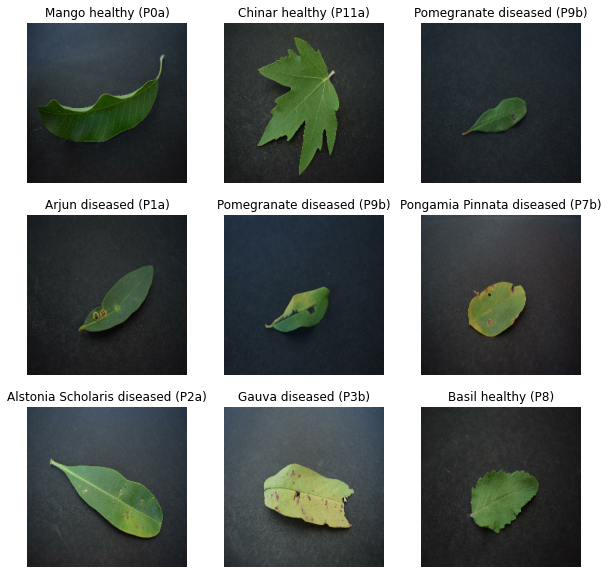

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[np.argmax(labels[i])])
    plt.axis("off")

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    rotation_range=5,
    zoom_range = (0.95, 0.95),
    horizontal_flip=False,
    vertical_flip=False,
    data_format='channels_last', #channels_last
    validation_split=0.0,
)

train_gen = train_datagen.flow_from_directory('/content/Plants_2/train/',
                                        target_size=(224, 224),
                                        batch_size=32,
                                        color_mode='rgb',
                                        class_mode='categorical', #binary, sparse
                                        shuffle=True,
                                        subset=None)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

validation_gen = test_datagen.flow_from_directory('/content/Plants_2/test/',
                                        target_size=(224, 224),
                                        batch_size=32,
                                        color_mode='rgb',
                                        class_mode='categorical', #binary, sparse
                                        shuffle=True,
                                        subset=None)

Found 4274 images belonging to 22 classes.
Found 110 images belonging to 22 classes.


In [ ]:
for img_batch, label_batch in train_gen:
  print(img_batch.shape, label_batch.shape)
  break

In [ ]:
train_ds.class_names
# train_gen.class_indices

In [ ]:
growth_rate =  32
filters =  32
n_dense_blocks = 4
n_dense_block_layers = 12

def dense_block(x, n_layers, filters, drop_rate=0.2, kernel_1=1, kernel_2=3):
    
  previous_input = x
  for i in range(n_layers):
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Conv2D(filters=4*filters, kernel_size=kernel_1, activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=drop_rate)(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_2, activation='relu', padding='same')(x)
    x = tf.keras.layers.Dropout(rate=drop_rate)(x)
    x = tf.keras.layers.Concatenate(axis=-1)([previous_input, x])  #Concatenate channel wise
    previous_input = x

  return x


def transition_layer(x, kernel=1, drop_rate=0.2):
  x = tf.keras.layers.BatchNormalization(axis=-1)(x)
  x = tf.keras.layers.Conv2D(filters=x.shape[-1]//2, kernel_size=1, activation='relu')(x)
  x = tf.keras.layers.Dropout(rate=drop_rate)(x)
  x = tf.keras.layers.AveragePooling2D(pool_size=2, strides=2)(x)
  # x = tf.keras.layers.GlobalAveragePooling2D(pool_size=2, strides=2)
  # x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)
  return x


input_x = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=7, strides=2, padding='same', input_shape=(224, 224, 3))(input_x)
x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
# x = tf.keras.layers.GlobalMaxPool2D(pool_size=3, strides=2)(x)

for i in range(n_dense_blocks): 
  print(i, x.shape)
  x = dense_block(x, n_dense_block_layers, filters)
  x = transition_layer(x)

print(i, x.shape)


x = dense_block(x, 32, filters)
print(i, x.shape)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(units=len(train_ds.class_names), activation='softmax')(x)

model = tf.keras.models.Model(input_x, output)

0 (None, 56, 56, 64)
1 (None, 28, 28, 224)
2 (None, 14, 14, 304)
3 (None, 7, 7, 344)
3 (None, 3, 3, 364)
3 (None, 3, 3, 1388)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.508165 to fit



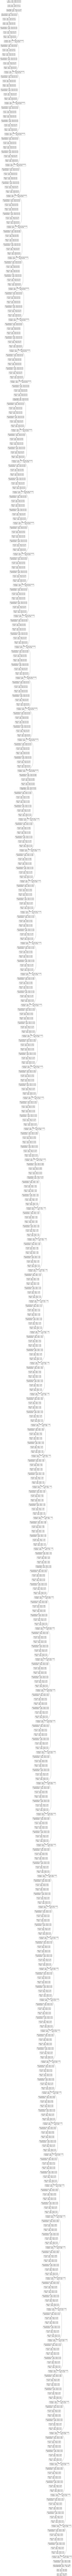

In [ ]:
# model.summary()
tf.keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.1), 
              metrics=["accuracy"])

model.fit(train_ds, epochs=2, steps_per_epoch=len(train_ds)//3, validation_data=valid_ds, validation_steps=len(valid_ds)//3)

Found 4274 files belonging to 22 classes.
Found 110 files belonging to 22 classes.
Epoch 1/2
